# Cats vs Dogs Classification using CNN

## Introduction

In this project, we'll explore a Convolutional Neural Network (CNN) for classifying images of cats and dogs. The dataset includes a mix of both cat and dog images.

![cat_dog](https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg)

## Data Exploration

Let's start by loading and exploring the dataset. We'll visualize a few random images to get a sense of the data.

In [1]:
import os
import zipfile
import random
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, load_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")
    
# Load the images
main_dir = "/kaggle/working/"
train_dir = "train"
path = os.path.join(main_dir, train_dir)

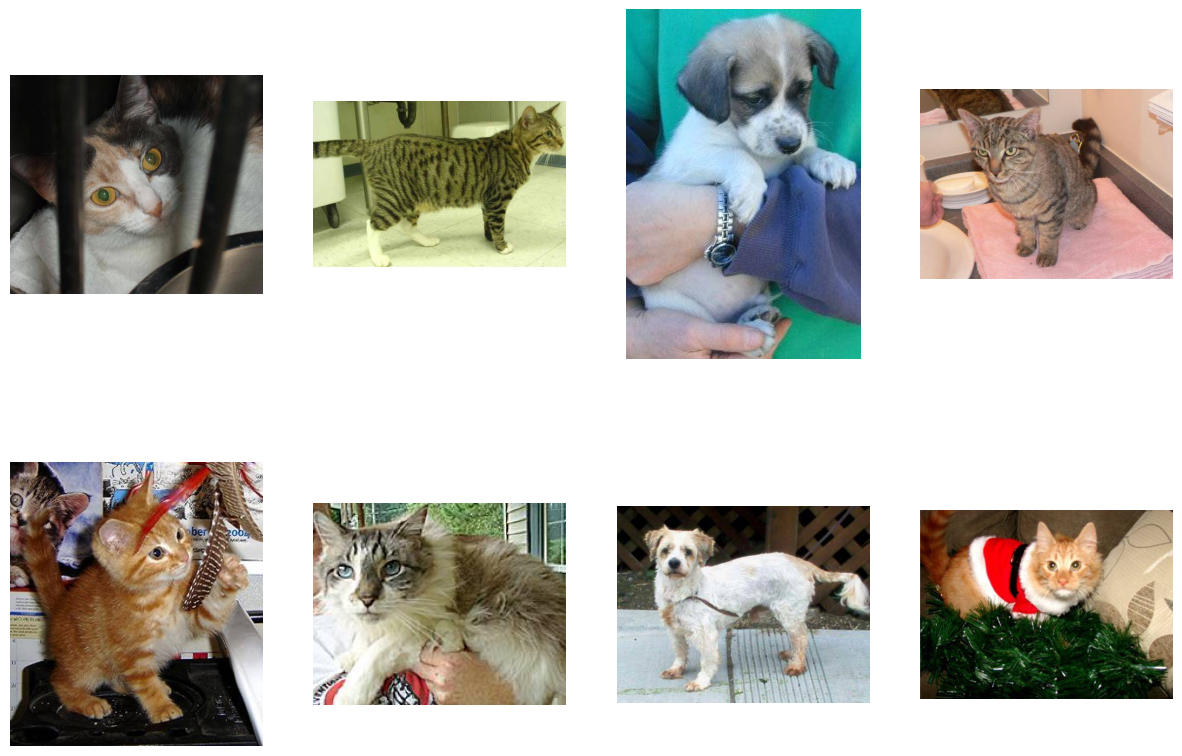

In [3]:
# Display 8 random color images from the train folder
plt.figure(figsize=(15, 10))
for i in range(8):
    random_file = random.choice(os.listdir(path))
    img_array = cv2.imread(os.path.join(path, random_file))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img_array)
    plt.axis('off')
plt.show()

# Data Preprocessing

We'll preprocess the images, normalize pixel values, and split the data into training and validation sets.

In [4]:
# Function to load and preprocess images
def load_and_preprocess_images(directory, img_size=(80, 80)):
    images = []
    labels = []

    for filename in os.listdir(directory):
        category = filename.split('.')[0]
        img_array = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=img_size)
        images.append(new_img_array)
        labels.append(1 if 'dog' in category else 0)  # Assuming 'dog' is positive class, 'cat' is negative

    return np.array(images), np.array(labels)

# Load and preprocess images
images, labels = load_and_preprocess_images(path, img_size=(80, 80))

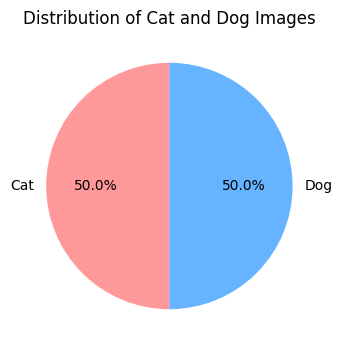

In [5]:
# Assuming labels are binary (0 for dog, 1 for cat)
cat_count = np.sum(labels == 0)
dog_count = np.sum(labels == 1)

labels_count = [cat_count, dog_count]
labels_names = ['Cat', 'Dog']

# Plotting the pie chart
plt.figure(figsize=(4, 4))
plt.pie(labels_count, labels=labels_names, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Cat and Dog Images')
plt.show()

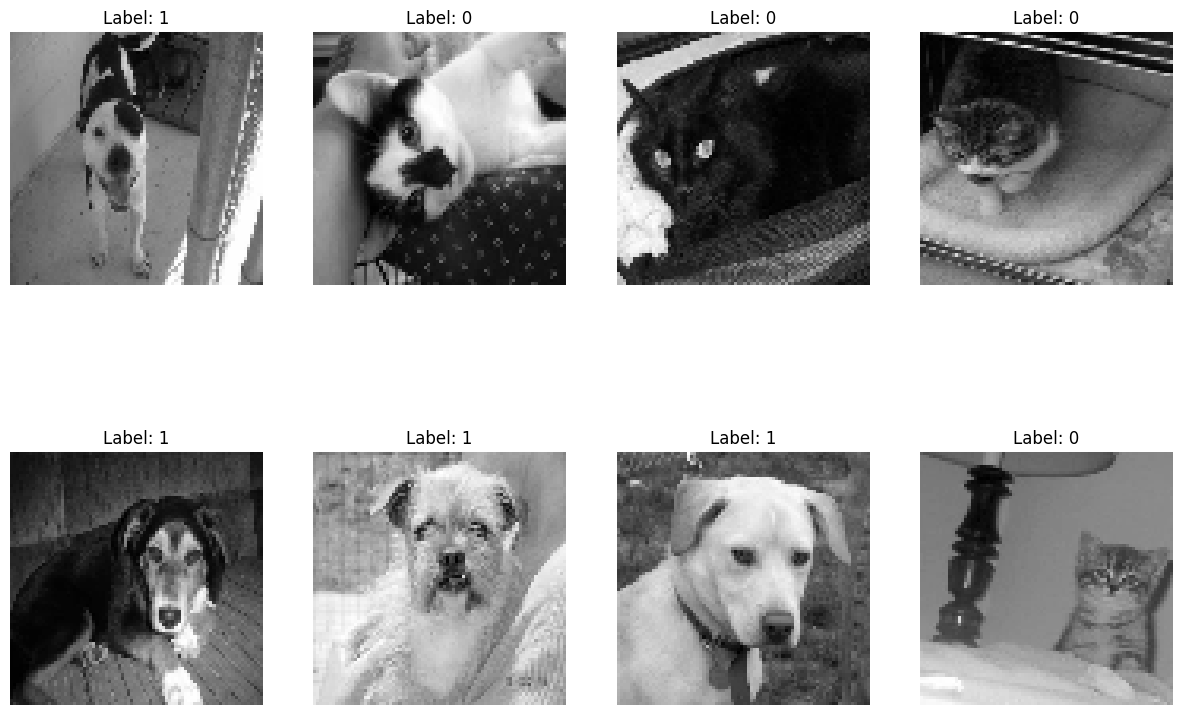

In [6]:
# Display 8 random images after labeling
plt.figure(figsize=(15, 10))
for i in range(8):
    random_index = random.randint(0, len(images)-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(images[random_index], cmap='gray')
    plt.title(f"Label: {labels[random_index]}")
    plt.axis('off')

plt.show()

In [7]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, val_images = train_images / 255.0, val_images / 255.0

In [8]:
# Create an ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for both training and validation data with augmentation
train_generator = train_datagen.flow(
    train_images.reshape((-1, 80, 80, 1)),
    train_labels,
    batch_size=32
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(
    val_images.reshape((-1, 80, 80, 1)),
    val_labels,
    batch_size=32
)

# Model Training
The model is trained using an ImageDataGenerator with data augmentation for the training set.

In [9]:
# Define the revised model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=binary_crossentropy, metrics=['accuracy'])

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the generator for both training and validation
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
625/625 [==============================] - 28s 28ms/step - loss: 0.6888 - accuracy: 0.6244 - val_loss: 0.6930 - val_accuracy: 0.5512
Epoch 2/20
625/625 [==============================] - 18s 28ms/step - loss: 0.6126 - accuracy: 0.6629 - val_loss: 0.5746 - val_accuracy: 0.6990
Epoch 3/20
625/625 [==============================] - 17s 28ms/step - loss: 0.5844 - accuracy: 0.6910 - val_loss: 0.5429 - val_accuracy: 0.7286
Epoch 4/20
625/625 [==============================] - 18s 28ms/step - loss: 0.5575 - accuracy: 0.7118 - val_loss: 0.5986 - val_accuracy: 0.7004
Epoch 5/20
625/625 [==============================] - 17s 27ms/step - loss: 0.5459 - accuracy: 0.7196 - val_loss: 0.6664 - val_accuracy: 0.6696
Epoch 6/20
625/625 [==============================] - 17s 28ms/step - loss: 0.5203 - accuracy: 0.7387 - val_loss: 0.5100 - val_accuracy: 0.7454
Epoch 7/20
625/625 [==============================] - 18s 28ms/step - loss: 0.5095 - accuracy: 0.7509 - val_loss: 0.5469 - val_accuracy:

# Model Evaluation
We evaluate the model's performance using metrics like precision, recall, and F1 score.

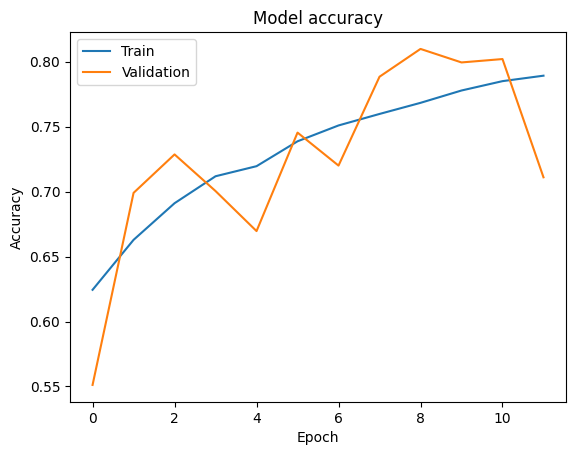

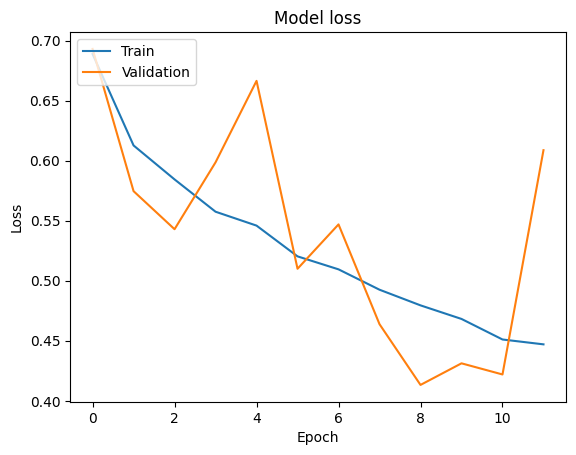

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

157/157 [==============================] - 1s 4ms/step


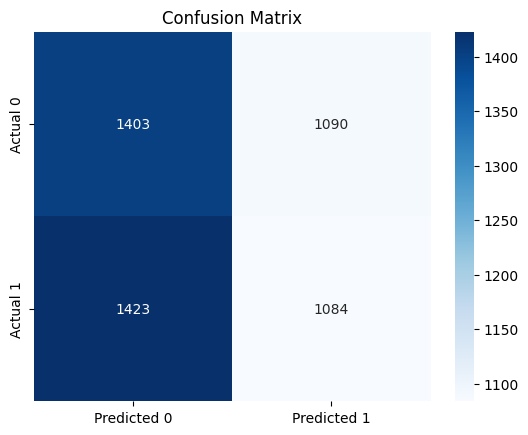

In [11]:
# Predict classes for validation set
y_pred = (model.predict(val_generator) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(val_labels, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

In [12]:
precision = precision_score(val_labels, y_pred)
recall = recall_score(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.4986
Recall: 0.4324
F1 Score: 0.4631


157/157 [==============================] - 1s 3ms/step


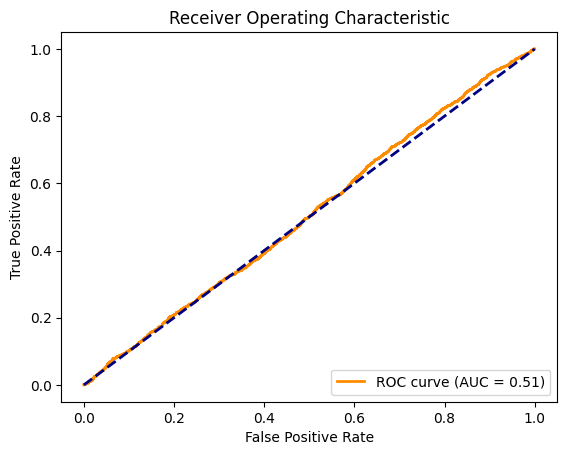

In [13]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(val_labels, model.predict(val_generator))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Hyperparameter Tuning
We perform hyperparameter tuning using Keras Tuner to find the optimal set of hyperparameters for our model.

In [14]:
# Function to build the model with hyperparameters
def create_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(80, 80, 1)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(hp.Int('conv3_units', min_value=32, max_value=128, step=32), (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.3, max_value=0.7, step=0.1)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss=binary_crossentropy,
        metrics=['accuracy']
    )

    return model

# Set up hyperparameter tuner
model_hp = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='keras_tuner_dir',
    project_name='cats_vs_dogs'
)

# Perform the hyperparameter search with Early Stopping
model_hp.search(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Trial 20 Complete [00h 01m 12s]
val_accuracy: 0.5267999768257141

Best val_accuracy So Far: 0.774399995803833
Total elapsed time: 00h 46m 22s


# Best Model Training
Finally, we train the model using the best hyperparameters on the entire training set.

In [15]:
# Function to load and preprocess test images
def load_and_preprocess_test_images(directory, img_size=(80, 80)):
    images = []

    for filename in os.listdir(directory):
        img_array = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=img_size)
        images.append(new_img_array)

    return np.array(images)

# Directory containing test images
test_dir = "test1"
test_directory = os.path.join(main_dir, test_dir)

# Load and preprocess test images
test_images = load_and_preprocess_test_images(test_directory, img_size=(80, 80))

# Reshape test images to match the model's input shape
test_images = test_images.reshape((-1, 80, 80, 1))

# Get the best trial from the hyperparameter search
best_trial = model_hp.oracle.get_best_trials(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = create_model(best_trial.hyperparameters)

# Compile the model
best_model.compile(
    optimizer=Adam(learning_rate=best_trial.hyperparameters.get('learning_rate')),
    loss=binary_crossentropy,
    metrics=['accuracy']
)

# Set up early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the best model on the entire training data
best_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
625/625 [==============================] - 21s 29ms/step - loss: 0.7166 - accuracy: 0.6040 - val_loss: 0.6910 - val_accuracy: 0.5620
Epoch 2/20
  1/625 [..............................] - ETA: 28s - loss: 0.5480 - accuracy: 0.6875

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 17s 27ms/step - loss: 0.6297 - accuracy: 0.6507 - val_loss: 0.5988 - val_accuracy: 0.6768
Epoch 3/20
625/625 [==============================] - 17s 28ms/step - loss: 0.6050 - accuracy: 0.6707 - val_loss: 0.5721 - val_accuracy: 0.6966
Epoch 4/20
625/625 [==============================] - 17s 28ms/step - loss: 0.5883 - accuracy: 0.6856 - val_loss: 0.5855 - val_accuracy: 0.6952
Epoch 5/20
625/625 [==============================] - 17s 28ms/step - loss: 0.5768 - accuracy: 0.6955 - val_loss: 0.5204 - val_accuracy: 0.7440
Epoch 6/20
625/625 [==============================] - 17s 28ms/step - loss: 0.5626 - accuracy: 0.7038 - val_loss: 0.6010 - val_accuracy: 0.6710
Epoch 7/20
625/625 [==============================] - 17s 27ms/step - loss: 0.5506 - accuracy: 0.7157 - val_loss: 0.5058 - val_accuracy: 0.7570
Epoch 8/20
625/625 [==============================] - 18s 28ms/step - loss: 0.5414 - accuracy: 0.7248 - val_loss: 0.4913 - val_accuracy: 0.7666
Epo

In [16]:
# Load the best model from the saved file
best_model = load_model('best_model.h5')

# Use the best model to make predictions on the test data
test_predictions = best_model.predict(test_images)

391/391 [==============================] - 1s 3ms/step


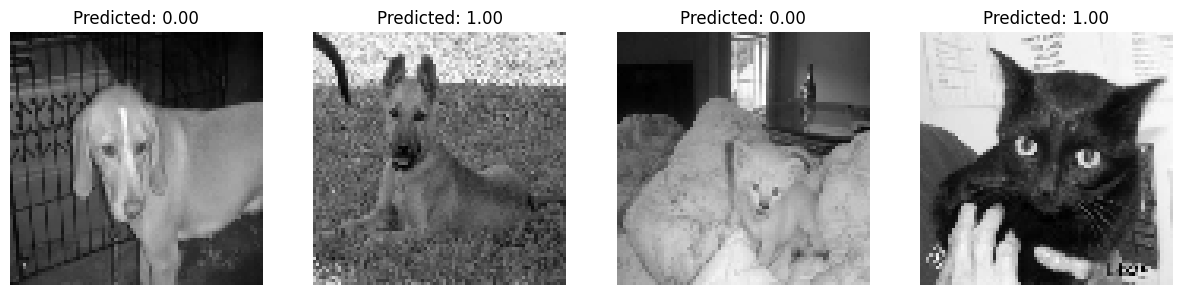

In [17]:
# Display some predicted images
def display_predicted_images(images, predictions, num_images=4):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape((80, 80)), cmap='gray')
        plt.title(f'Predicted: {predictions[i][0]:.2f}')
        plt.axis('off')
    plt.show()

# Display predicted images with actual labels
display_predicted_images(test_images, test_predictions, num_images=4)

# Conclusion
In conclusion, our model achieved satisfactory performance in classifying cat and dog images. We've demonstrated the process of data preprocessing, model building, training, and evaluation.

# Made by: Abdelrahman Eldaba